In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# print(os.listdir("../input/glove-global-vectors-for-word-representation"))
# print(os.listdir("../input/jigsaw-unintended-bias-in-toxicity-classification"))

# Any results you write to the current directory are saved as output.

['crawl-300d-2M.gensim', 'crawl-300d-2M.vec.zip', 'fasttext-crawl-300d-2m', 'glove-global-vectors-for-word-representation', 'glove.840B.300d.gensim', 'glove.840B.300d.txt.zip', 'glove840b300dtxt', 'jigsaw-unintended-bias-in-toxicity-classification']


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
import numpy as np
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

from sklearn import metrics
from sklearn import model_selection

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model

## Load and pre-process the data set

In [3]:
#train = pd.read_csv('../data/train.csv', nrows=1000)
train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
print('loaded %d records' % len(train))

# Make sure all comment_text values are strings
train['comment_text'] = train['comment_text'].astype(str) 

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

train = convert_dataframe_to_bool(train)

loaded 1804874 records


In [4]:
identity_columns_all = [
    'asian', 'atheist', 'bisexual',
    'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
    'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
    'jewish', 'latino', 'male', 'muslim', 'other_disability',
    'other_gender', 'other_race_or_ethnicity', 'other_religion',
    'other_sexual_orientation', 'physical_disability',
    'psychiatric_or_mental_illness', 'transgender', 'white'
]

### Subset training data for ease of computation

In [5]:
train = train.sample(frac=0.1, random_state=0)

## Split the data into 80% train and 20% validate sets

In [6]:
train_df, validate_df = model_selection.train_test_split(train, test_size=0.2, random_state=0)
print('%d train comments, %d validate comments' % (len(train_df), len(validate_df)))


144389 train comments, 36098 validate comments


## Create a text tokenizer

In [7]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

## Define and train a Convolutional Neural Net for classifying toxic comments

In [8]:
EMBEDDINGS_PATH = '../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'
EMBEDDINGS_DIMENSION = 100
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005
NUM_EPOCHS = 10
BATCH_SIZE = 128

def train_model(train_df, validate_df, tokenizer):
    # Prepare data
    train_text = pad_text(train_df[TEXT_COLUMN], tokenizer)
    train_labels = to_categorical(train_df[TOXICITY_COLUMN])
    validate_text = pad_text(validate_df[TEXT_COLUMN], tokenizer)
    validate_labels = to_categorical(validate_df[TOXICITY_COLUMN])

    # Load embeddings
    print('loading embeddings')
    embeddings_index = {}
    with open(EMBEDDINGS_PATH, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1,
                                 EMBEDDINGS_DIMENSION))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    # Create model layers.
    def get_convolutional_neural_net_layers():
        """Returns (input_layer, output_layer)"""
        sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
        embedding_layer = Embedding(len(tokenizer.word_index) + 1,
                                    EMBEDDINGS_DIMENSION,
                                    weights=[embedding_matrix],
                                    input_length=MAX_SEQUENCE_LENGTH,
                                    trainable=False)
        x = embedding_layer(sequence_input)
        x = Conv1D(128, 2, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 3, activation='relu', padding='same')(x)
        x = MaxPooling1D(5, padding='same')(x)
        x = Conv1D(128, 4, activation='relu', padding='same')(x)
        x = MaxPooling1D(40, padding='same')(x)
        x = Flatten()(x)
        x = Dropout(DROPOUT_RATE)(x)
        x = Dense(128, activation='relu')(x)
        preds = Dense(2, activation='softmax')(x)
        return sequence_input, preds

    # Compile model.
    print('compiling model')
    input_layer, output_layer = get_convolutional_neural_net_layers()
    model = Model(input_layer, output_layer)
    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=LEARNING_RATE),
                  metrics=['acc'])

    # Train model.
    print('training model')
    model.fit(train_text,
              train_labels,
              batch_size=BATCH_SIZE,
              epochs=NUM_EPOCHS,
              validation_data=(validate_text, validate_labels),
              verbose=2)

    return model

model = train_model(train_df, validate_df, tokenizer)

loading embeddings
compiling model
training model
Epoch 1/10
1129/1129 - 217s - loss: 0.2705 - acc: 0.9195 - val_loss: 0.2342 - val_acc: 0.9191
Epoch 2/10
1129/1129 - 206s - loss: 0.2229 - acc: 0.9234 - val_loss: 0.2090 - val_acc: 0.9254
Epoch 3/10
1129/1129 - 196s - loss: 0.2022 - acc: 0.9283 - val_loss: 0.1970 - val_acc: 0.9298
Epoch 4/10
1129/1129 - 184s - loss: 0.1900 - acc: 0.9321 - val_loss: 0.1885 - val_acc: 0.9317
Epoch 5/10
1129/1129 - 183s - loss: 0.1817 - acc: 0.9353 - val_loss: 0.2076 - val_acc: 0.9227
Epoch 6/10
1129/1129 - 178s - loss: 0.1763 - acc: 0.9376 - val_loss: 0.2010 - val_acc: 0.9240
Epoch 7/10
1129/1129 - 180s - loss: 0.1714 - acc: 0.9393 - val_loss: 0.1776 - val_acc: 0.9365
Epoch 8/10
1129/1129 - 187s - loss: 0.1671 - acc: 0.9401 - val_loss: 0.1811 - val_acc: 0.9331
Epoch 9/10
1129/1129 - 190s - loss: 0.1636 - acc: 0.9414 - val_loss: 0.1754 - val_acc: 0.9371
Epoch 10/10
1129/1129 - 198s - loss: 0.1601 - acc: 0.9425 - val_loss: 0.1783 - val_acc: 0.9381


## Generate model predictions on the validation set

In [9]:
MODEL_NAME = 'my_model'
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

<ipython-input-9-444587f42c11>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]


## AUDIT: Evaluate FPR and FNR for protected features

In [11]:
identity_columns_race = [
    'asian', 'black', 'latino', 'other_race_or_ethnicity', 'white']
identity_columns_religion = [
    'atheist', 'buddhist', 'christian', 'hindu',
    'jewish', 'muslim', 'other_religion']
identity_columns_sexuality = [
    'bisexual','heterosexual','homosexual_gay_or_lesbian', 
    'other_sexual_orientation']
identity_columns_gender = [
    'female', 'male', 'other_gender', 'transgender']
identity_columns_disability = [
    'intellectual_or_learning_disability', 'other_disability',
    'physical_disability','psychiatric_or_mental_illness']

In [12]:
# add predict column for binary predictions
label = TOXICITY_COLUMN

def get_subgroup(df, subgroup):
    return df[subgroup] > df[subgroup].mean()

def compute_acc(df, model_predict):
    correct = df[df[label] == df[model_predict]]
    acc = len(correct)/len(df)
    return acc
    
def compute_fnr(df, model_predict):
    p = df[df[label]]
    fn = df[df[label] & ~df[model_predict]]
    fnr = len(fn)/len(p)
    return fnr

def compute_fpr(df, model_predict):
    n = df[~df[label]]
    fp = df[~df[label] & df[model_predict]]
    fpr = len(fp)/len(n)
    return fpr

def compute_subgroup_fpr_fnr(dataset, subgroups, model_predict):
    """Computes per-subgroup metrics (FPR and FNR) for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        df_subgroup = get_subgroup(dataset, subgroup)
        df_subgroup = dataset[df_subgroup]
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(df_subgroup)
        }
        record["ACC"] = compute_acc(df_subgroup, model_predict)
        record["FPR"] = compute_fpr(df_subgroup, model_predict)
        record["FNR"] = compute_fnr(df_subgroup, model_predict)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_size', ascending=True)

def compute_all_fpr_fnr(dataset, model_predict):
    
    print("Check Metrics for All Validation Predictions:")
    overall_fpr = compute_fpr(dataset, model_predict)
    overall_fnr = compute_fnr(dataset, model_predict)
    overall_acc = compute_acc(dataset, model_predict)
    print('FPR = {}\nFNR = {}\nACC = {}\n'.format(overall_fpr,overall_fnr,overall_acc))

    print("Metrics by attributes:")
    race = compute_subgroup_fpr_fnr(dataset, identity_columns_race, model_predict)
    religion = compute_subgroup_fpr_fnr(dataset, identity_columns_religion, model_predict)
    sexuality = compute_subgroup_fpr_fnr(dataset, identity_columns_sexuality, model_predict)
    gender = compute_subgroup_fpr_fnr(dataset, identity_columns_gender, model_predict)
    disability = compute_subgroup_fpr_fnr(dataset, identity_columns_disability, model_predict)
    print(race)
    print(religion)
    print(sexuality)
    print(gender)
    print(disability)
    
    return overall_fpr, overall_fnr, overall_acc, race, religion, sexuality, gender, disability

# overall_fpr, overall_fnr, overall_acc, race, religion, sexuality, gender, disability = compute_all_fpr_fnr(validate_df_predict, MODEL_NAME)

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def concat_dfs(df_list):
    df1 = df_list[0]
    for i in range(1, len(df_list)):
        df2 = df_list[i]
        df1 = pd.concat([df1, df2])
    return df1

def boxplot_dfs(df, att):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
    sns.boxplot(x='subgroup', y='ACC', data=df, linewidth=0.5, ax=axs[0])
    sns.boxplot(x='subgroup', y='FPR', data=df, linewidth=0.5, ax=axs[1])
    sns.boxplot(x='subgroup', y='FNR', data=df, linewidth=0.5, ax=axs[2])
    axs[0].set_title("ACC for {} Subgroups".format(att))
    axs[1].set_title("FPR for {} Subgroups".format(att))
    axs[2].set_title("FNR for {} Subgroups".format(att))
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
    axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)
    plt.show()

In [48]:
# create multiple models
iterations = 10
thresh = 0.5
model_names = []
metrics_overall_fpr = []
metrics_overall_fnr = []
metrics_overall_acc = []
metrics_race = []
metrics_religion = []
metrics_sexuality = []
metrics_gender = []
metrics_disability = []

for i in range(iterations):
    print("===============================================================================")
    print("===============================  Iteration={}  =================================".format(i))
    print("===============================================================================")

    bootstrap_idx = np.random.choice(len(train_df), len(train_df))
    bootstrap_train_df = train_df.iloc[bootstrap_idx, :]

    model = train_model(bootstrap_train_df, validate_df, tokenizer)
    model_name = "model_{}".format(i)
    
    # get binary predictions
    predict = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]
    validate_df_predict = validate_df.copy()
    validate_df_predict.loc[:, model_name] = predict > thresh
    overall_fpr, overall_fnr, overall_acc, race, religion, sexuality, gender, disability = compute_all_fpr_fnr(validate_df_predict, model_name)
    
    # save results
    model_names.append(model_name)
    metrics_overall_fpr.append(overall_fpr)
    metrics_overall_fnr.append(overall_fnr) 
    metrics_overall_acc.append(overall_acc) 
    metrics_race.append(race) 
    metrics_religion.append(religion) 
    metrics_sexuality.append(sexuality) 
    metrics_gender.append(gender) 
    metrics_disability.append(disability)

===============================  Iteration=0  =================================
loading embeddings
compiling model
training model
Epoch 1/10
1129/1129 - 87s - loss: 0.2698 - acc: 0.9199 - val_loss: 0.2440 - val_acc: 0.9191
Epoch 2/10
1129/1129 - 85s - loss: 0.2164 - acc: 0.9249 - val_loss: 0.2083 - val_acc: 0.9265
Epoch 3/10
1129/1129 - 91s - loss: 0.1936 - acc: 0.9314 - val_loss: 0.1966 - val_acc: 0.9309
Epoch 4/10
1129/1129 - 101s - loss: 0.1807 - acc: 0.9356 - val_loss: 0.1877 - val_acc: 0.9322
Epoch 5/10
1129/1129 - 118s - loss: 0.1716 - acc: 0.9390 - val_loss: 0.2096 - val_acc: 0.9332
Epoch 6/10
1129/1129 - 115s - loss: 0.1643 - acc: 0.9412 - val_loss: 0.1828 - val_acc: 0.9350
Epoch 7/10
1129/1129 - 118s - loss: 0.1573 - acc: 0.9437 - val_loss: 0.1898 - val_acc: 0.9365
Epoch 8/10
1129/1129 - 120s - loss: 0.1506 - acc: 0.9457 - val_loss: 0.1897 - val_acc: 0.9302
Epoch 9/10
1129/1129 - 120s - loss: 0.1439 - acc: 0.9484 - val_loss: 0.2214 - val_acc: 0.9354
Epoch 10/10
1129/1129 - 122

loading embeddings
compiling model
training model
Epoch 1/10
1129/1129 - 107s - loss: 0.2768 - acc: 0.9196 - val_loss: 0.2552 - val_acc: 0.9181
Epoch 2/10
1129/1129 - 120s - loss: 0.2299 - acc: 0.9225 - val_loss: 0.2263 - val_acc: 0.9204
Epoch 3/10
1129/1129 - 113s - loss: 0.2057 - acc: 0.9273 - val_loss: 0.2218 - val_acc: 0.9183
Epoch 4/10
1129/1129 - 117s - loss: 0.1910 - acc: 0.9321 - val_loss: 0.2008 - val_acc: 0.9309
Epoch 5/10
1129/1129 - 115s - loss: 0.1796 - acc: 0.9357 - val_loss: 0.2062 - val_acc: 0.9323
Epoch 6/10
1129/1129 - 116s - loss: 0.1711 - acc: 0.9388 - val_loss: 0.1871 - val_acc: 0.9324
Epoch 7/10
1129/1129 - 118s - loss: 0.1633 - acc: 0.9413 - val_loss: 0.1908 - val_acc: 0.9370
Epoch 8/10
1129/1129 - 116s - loss: 0.1565 - acc: 0.9439 - val_loss: 0.1866 - val_acc: 0.9358
Epoch 9/10
1129/1129 - 118s - loss: 0.1495 - acc: 0.9465 - val_loss: 0.1973 - val_acc: 0.9373
Epoch 10/10
1129/1129 - 112s - loss: 0.1437 - acc: 0.9485 - val_loss: 0.1979 - val_acc: 0.9370
Check Met

loading embeddings
compiling model
training model
Epoch 1/10
1129/1129 - 107s - loss: 0.2700 - acc: 0.9198 - val_loss: 0.2371 - val_acc: 0.9183
Epoch 2/10
1129/1129 - 111s - loss: 0.2205 - acc: 0.9232 - val_loss: 0.2079 - val_acc: 0.9253
Epoch 3/10
1129/1129 - 110s - loss: 0.1975 - acc: 0.9298 - val_loss: 0.2064 - val_acc: 0.9285
Epoch 4/10
1129/1129 - 104s - loss: 0.1842 - acc: 0.9341 - val_loss: 0.1993 - val_acc: 0.9268
Epoch 5/10
1129/1129 - 102s - loss: 0.1746 - acc: 0.9375 - val_loss: 0.1874 - val_acc: 0.9333
Epoch 6/10
1129/1129 - 103s - loss: 0.1670 - acc: 0.9402 - val_loss: 0.1853 - val_acc: 0.9326
Epoch 7/10
1129/1129 - 115s - loss: 0.1595 - acc: 0.9428 - val_loss: 0.1996 - val_acc: 0.9356
Epoch 8/10
1129/1129 - 110s - loss: 0.1528 - acc: 0.9453 - val_loss: 0.1897 - val_acc: 0.9363
Epoch 9/10
1129/1129 - 111s - loss: 0.1470 - acc: 0.9479 - val_loss: 0.1926 - val_acc: 0.9360
Epoch 10/10
1129/1129 - 111s - loss: 0.1403 - acc: 0.9500 - val_loss: 0.1896 - val_acc: 0.9336
Check Met

loading embeddings
compiling model
training model
Epoch 1/10
1129/1129 - 110s - loss: 0.2751 - acc: 0.9183 - val_loss: 0.2423 - val_acc: 0.9182
Epoch 2/10
1129/1129 - 111s - loss: 0.2270 - acc: 0.9215 - val_loss: 0.2155 - val_acc: 0.9234
Epoch 3/10
1129/1129 - 111s - loss: 0.2036 - acc: 0.9272 - val_loss: 0.2047 - val_acc: 0.9278
Epoch 4/10
1129/1129 - 110s - loss: 0.1881 - acc: 0.9323 - val_loss: 0.1915 - val_acc: 0.9311
Epoch 5/10
1129/1129 - 110s - loss: 0.1769 - acc: 0.9361 - val_loss: 0.1956 - val_acc: 0.9333
Epoch 6/10
1129/1129 - 110s - loss: 0.1685 - acc: 0.9390 - val_loss: 0.1880 - val_acc: 0.9342
Epoch 7/10
1129/1129 - 110s - loss: 0.1613 - acc: 0.9414 - val_loss: 0.1910 - val_acc: 0.9352
Epoch 8/10
1129/1129 - 115s - loss: 0.1542 - acc: 0.9441 - val_loss: 0.2025 - val_acc: 0.9355
Epoch 9/10
1129/1129 - 111s - loss: 0.1483 - acc: 0.9462 - val_loss: 0.2008 - val_acc: 0.9365
Epoch 10/10
1129/1129 - 110s - loss: 0.1430 - acc: 0.9481 - val_loss: 0.2236 - val_acc: 0.9350
Check Met

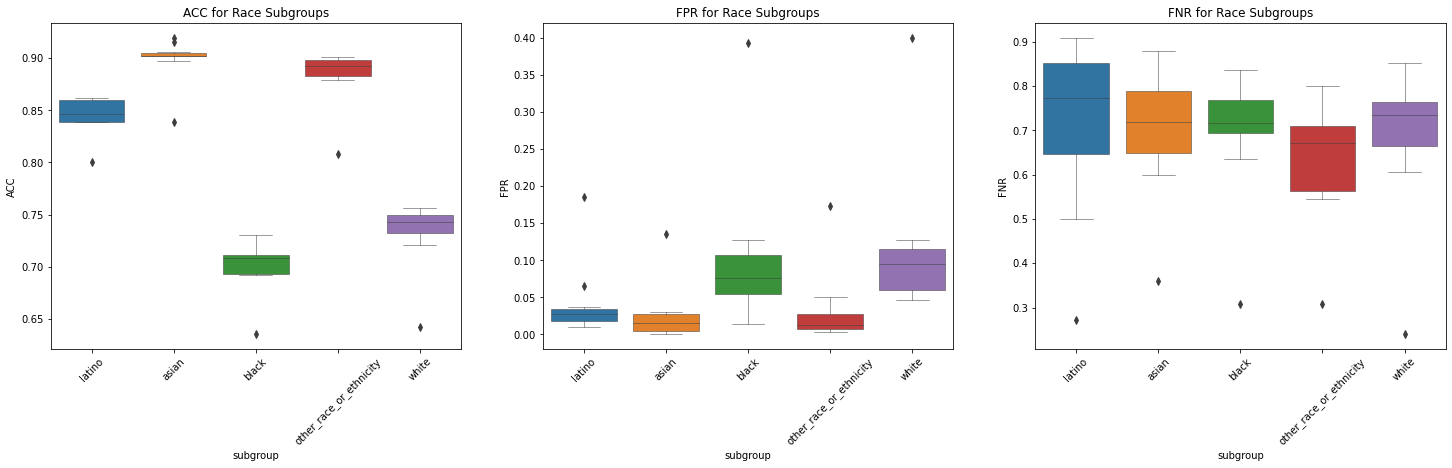

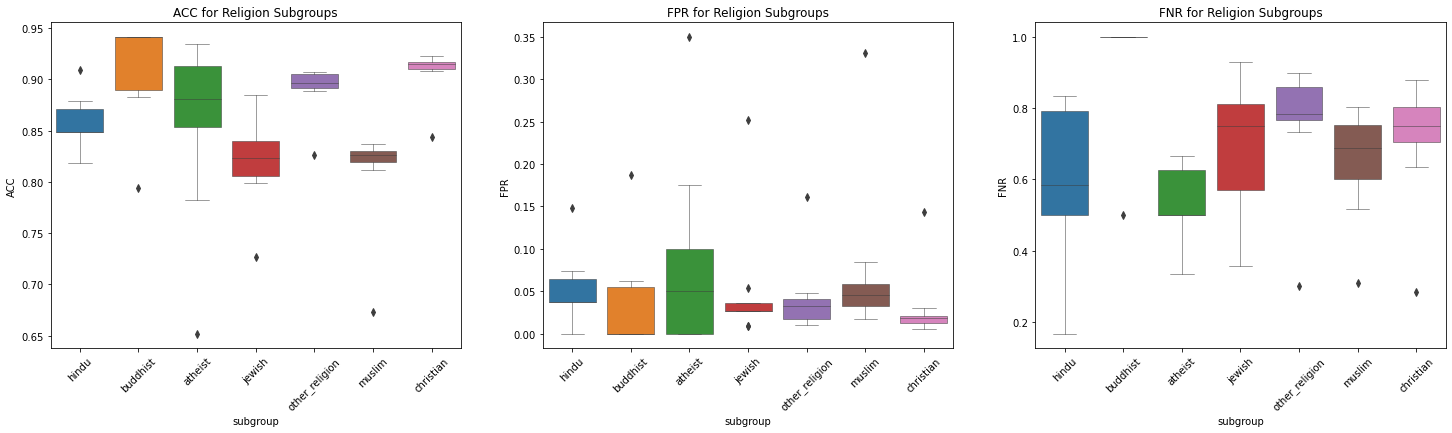

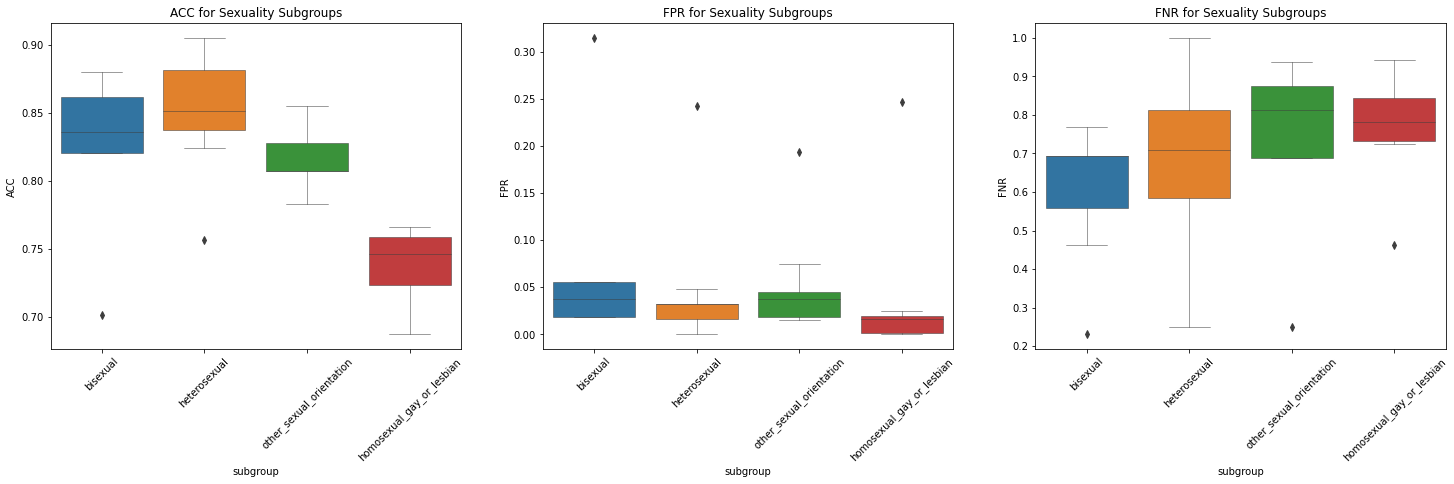

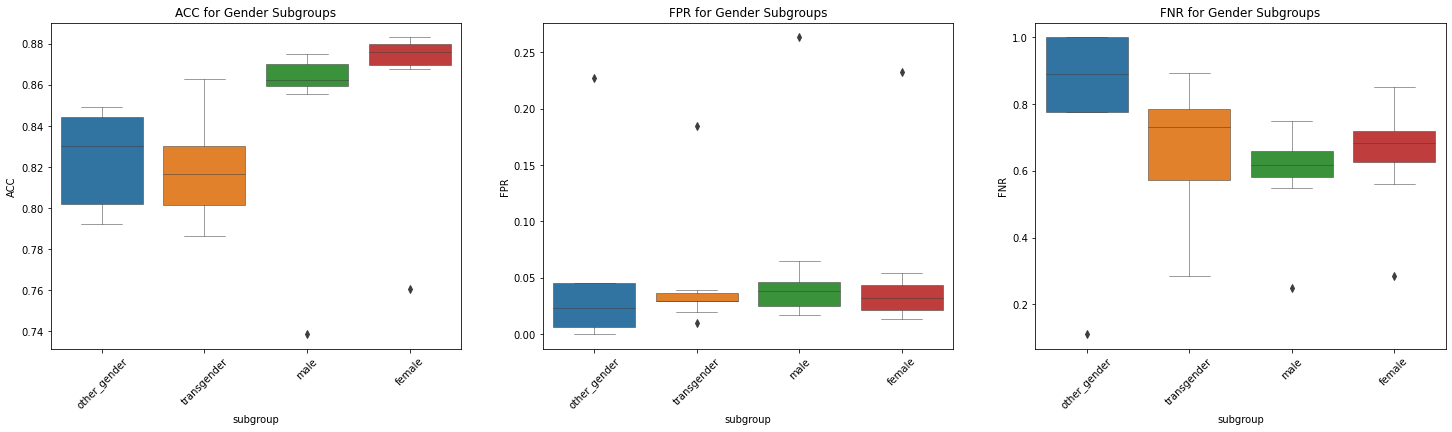

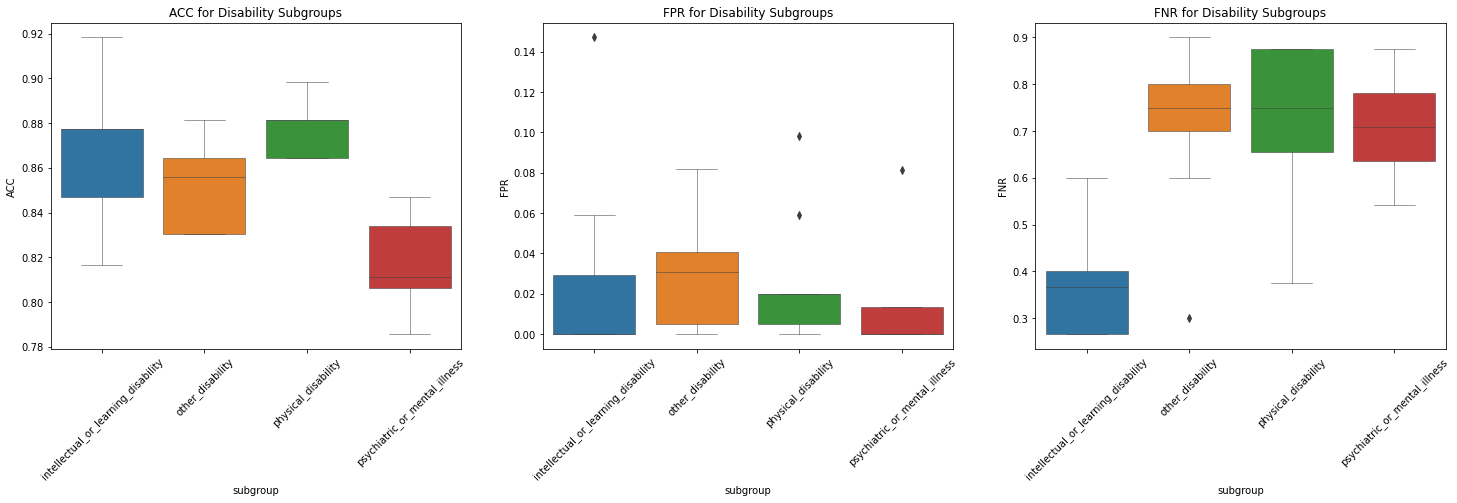

In [49]:
df_race = concat_dfs(metrics_race)
df_religion = concat_dfs(metrics_religion)
df_sexuality = concat_dfs(metrics_sexuality)
df_gender = concat_dfs(metrics_gender)
df_disability = concat_dfs(metrics_disability)

boxplot_dfs(df_race, "Race")
boxplot_dfs(df_religion, "Religion")
boxplot_dfs(df_sexuality, "Sexuality")
boxplot_dfs(df_gender, "Gender")
boxplot_dfs(df_disability, "Disability")

## Define bias metrics, then evaluate our new model for bias using the validation set predictions

In [10]:
MODEL_NAME="my_model"
validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(validate_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df


<ipython-input-10-1d6b1ecbd467>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate_df[MODEL_NAME] = model.predict(pad_text(validate_df[TEXT_COLUMN], tokenizer))[:, 1]


,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
7,white,534,0.745796,0.738832,0.922289
6,black,315,0.748359,0.757065,0.907939
2,homosexual_gay_or_lesbian,227,0.781783,0.830528,0.878998
5,muslim,447,0.825704,0.773116,0.943594
8,psychiatric_or_mental_illness,98,0.826577,0.908092,0.826843
0,male,873,0.836382,0.803792,0.932160
1,female,1052,0.855858,0.823472,0.925211
4,jewish,139,0.881113,0.827358,0.943589
3,christian,805,0.886281,0.881122,0.907277


In [11]:
bias_metrics_df.to_latex("original_bias_metrics.tex")

## Calculate the final score

In [15]:
def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
get_final_metric(bias_metrics_df, calculate_overall_auc(validate_df, MODEL_NAME))

0.8507983213248442

## Prediction on Test data

In [118]:
test = pd.read_csv('../data/test.csv')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [119]:
test.shape

(97320, 2)

In [12]:
#submission['prediction'] = model.predict(pad_text(test[TEXT_COLUMN], tokenizer))[:, 1]
# submission.to_csv('submission.csv')